In [4]:
import numpy as np
import random 
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

# defining Pauli matrices & CNOT
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
CNOT = [[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]] # switch tensor control

# defining rotation gates
def Ry(A):
    M = np.array([[np.cos(A/2),-np.sin(A/2)],[np.sin(A/2), np.cos(A/2)]])
    return M
def Rz(A):
    M = np.array([[np.exp(-1j*A/2),0],[0,np.exp(1j*A/2)]])
    return M
    
# Parameterising the general unitary with rotation gates
def U (A0,A1,A2): # Arguments: Euler Angles
    M = Rz(A1)@Ry(A0)@Rz(A2)
    return M

# derivatives wrt A0,A1,A2
def DA0(A0,A1,A2):
    dA0 = (-1j/2)*(Rz(A1)@Y@Ry(A0)@Rz(A2))
    return dA0
def DA1(A0,A1,A2):
    dA1 = (-1j/2)*(Z@Rz(A1)@Ry(A0)@Rz(A2))
    return dA1
def DA2 (A0,A1,A2):
    dA2 = (-1j/2)*(Rz(A1)@Ry(A0)@Z@Rz(A2))
    return dA2

# defining inverse
def inverse(M):
    M_inverse = M.transpose().conjugate()
    return M_inverse



In [5]:
# function to define RHS for each unitary
def Utbm(j, A, U_goal): 
# j = unitary position, A = array of parameters, U_goal = U to be computed
    
    U1 = U(A[0,0],A[0,1],A[0,2])
    U2 = U(A[1,0],A[1,1],A[1,2])
    U3 = U(A[2,0],A[2,1],A[2,2])
    U4 = U(A[3,0],A[3,1],A[3,2])
    U5 = U(A[4,0],A[4,1],A[4,2])
    U6 = U(A[5,0],A[5,1],A[5,2])
    U7 = U(A[6,0],A[6,1],A[6,2])
    U8 = U(A[7,0],A[7,1],A[7,2])
    Ulist = [U1,U2,U3,U4,U5,U6,U7,U8]
    
    Ulist[j-1] = np.eye(2) # isolating unitary of interest
    
    U12 = np.kron(Ulist[0],Ulist[1])
    U34 = np.kron(Ulist[2],Ulist[3])
    U56 = np.kron(Ulist[4],Ulist[5])
    U78 = np.kron(Ulist[6],Ulist[7])

    # improvement: modulation possible
    if j==1:
        Uf = np.eye(4)
        Ub = U12@CNOT@U34@CNOT@U56@CNOT@U78
    elif j==2:
        Uf = U12
        Ub = CNOT@U34@CNOT@U56@CNOT@U78
    elif j==3:
        Uf = U12@CNOT
        Ub =U34@CNOT@U56@CNOT@U78
    elif j==4:
        Uf = U12@CNOT@U34
        Ub =CNOT@U56@CNOT@U78
    elif j==5:
        Uf = U12@CNOT@U34@CNOT
        Ub = U56@CNOT@U78
    elif j==6:
        Uf = U12@CNOT@U34@CNOT@U56
        Ub = CNOT@U78
    elif j==7:
        Uf = U12@CNOT@U34@CNOT@U56@CNOT
        Ub = U78
    elif j==8:
        Uf = U12@CNOT@U34@CNOT@U56@CNOT@U78
        Ub = np.eye(4)
    U_tbm = inverse(Uf)@U_goal@inverse(Ub) # U_tbm = rhs , U to be made
    return U_tbm

In [6]:
U_goal = unitary_group.rvs(4) # U to be achieved
print(U_goal)
# A = np.zeros((8,3))
# # randomly initialising the parameters
# for i in range(8):
#     for j in range(3):
#         A[i][j] = random.uniform(0.0, 4*np.pi) 

# print(U_goal)
# print(A)

[[-0.06247829-0.54388905j -0.27030968+0.45407674j  0.31208561-0.36755271j
   0.40843713-0.14735956j]
 [-0.27951612-0.22462484j -0.04370866+0.3445849j   0.18198308+0.7954186j
  -0.23790398-0.16839928j]
 [-0.31849589+0.12144032j  0.05298851+0.31733146j -0.28229951+0.12289636j
   0.38586372+0.73254231j]
 [ 0.65530065+0.16152169j  0.2556625 +0.6566791j  -0.07787517-0.02894655j
  -0.19942187+0.03506443j]]


In [7]:
# function to do gradient descent
def gradient_descent(A, iterations,alpha,U_goal): # A = array of parameters, alpha - learning rate
    
    Aopt = np.copy(A) # to separate input and output
    stop_flag=0
    for j in range(1,9):
        # rhs of the optimization
        Ui = Utbm(j,Aopt,U_goal)

        # defining LHS 
        A0=Aopt[j-1][0]
        A1=Aopt[j-1][1]
        A2=Aopt[j-1][2]
        
        U_initial= U(A0,A1,A2)
        if j%2!=0:
            Uxyz = np.kron(U_initial,np.eye(2))
           
        else:
            Uxyz = np.kron(np.eye(2), U_initial)
            
        for i in range(iterations):
            #defining cost function
            Tr = np.trace(Ui@inverse(Uxyz))
            Abs = np.abs(Tr)
            Uerr = 4 - Abs
            #print(Uerr)
            Uerr_array1.append(Uerr)
            if Uerr < 1e-8:
                stop_flag=1
                break
            else:
                #gradient 
                dA0 = DA0(A0,A1,A2)
                dA1 = DA1(A0,A1,A2)
                dA2 = DA2(A0,A1,A2)
                if j%2!=0:
                    UdA0 = np.kron(dA0,np.eye(2))
                    UdA1 = np.kron(dA1,np.eye(2))
                    UdA2 = np.kron(dA2,np.eye(2))
                else:
                    UdA0 = np.kron(np.eye(2),dA0)
                    UdA1 = np.kron(np.eye(2),dA1)
                    UdA2 = np.kron(np.eye(2),dA2)

                Grad_A0 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA0)))
                Grad_A0R = Grad_A0.real
                Grad_A1 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA1)))
                Grad_A1R = Grad_A1.real
                Grad_A2 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA2)))
                Grad_A2R = Grad_A2.real

                #updation
                A0 = A0 - alpha*Grad_A0R
                A1 = A1 - alpha*Grad_A1R
                A2 = A2 - alpha*Grad_A2R

                if j%2 != 0:
                    Uxyz = np.kron(U(A0,A1,A2),np.eye(2))
                else:
                    Uxyz = np.kron(np.eye(2), U(A0,A1,A2))
                Aopt[j-1][0]=A0
                Aopt[j-1][1]=A1
                Aopt[j-1][2]=A2
            if stop_flag==1:
                break

    return Aopt,stop_flag

### Covergence rates for 5 Unitaries 

In [12]:
# random initialisations & function call

for h in range(5):
    U_goal = unitary_group.rvs(4) # U to be achieved
    print("U_goal =" , U_goal) 
    A = np.zeros((8,3))
    # randomly initialising the parameters
    for i in range(8):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    
    AOpt1 =np.copy(A)
    print("Initial Parameters = ",AOpt1)
    # truncation condition
    stop_flag=0
    Uerr_array1=[] # to store error
    for i in range(10000):
        if stop_flag ==1:
            print("Truncation")
            break
        AOpt1,stop_flag = gradient_descent(AOpt1,10,0.01,U_goal)
    print("\nStarting error:",Uerr_array1[0])
    print("\nIterations:",len(Uerr_array1))
    plt.plot(np.log10(Uerr_array1))
    plt.title("Unitary "+str(h+1))
    plt.savefig("Unitary "+str(h+1))
    plt.close()
    



U_goal = [[-0.42311077+0.29687273j  0.40707598-0.16651193j  0.11649393+0.63253334j
  -0.27831999+0.21971687j]
 [ 0.3740149 +0.09046953j -0.1281452 +0.64205698j  0.22688145+0.08584081j
  -0.53903955+0.27177617j]
 [-0.43136182+0.49291805j -0.2338633 +0.30389788j -0.31877378-0.27499295j
   0.24177353+0.43384391j]
 [ 0.39354997-0.02914058j -0.13368634-0.46150468j -0.5862175 +0.08122873j
  -0.26083627+0.44173071j]]
Initial Parameters =  [[ 0.83832187  2.76672191  4.07872344]
 [ 3.71702656  0.89488917 11.79330906]
 [ 4.21369475  3.67228264  2.09904692]
 [ 1.68786091  2.5065472   5.03439511]
 [ 5.00333033  6.16838445  1.53412037]
 [ 8.76425813  1.65505155  3.03132455]
 [ 6.56600114  1.28333472  0.84421196]
 [ 2.99357407  6.40578153  0.80737031]]
Truncation

Starting error: 2.948076935012919

Iterations: 99653
U_goal = [[ 0.0951883 +0.91214558j  0.22712072+0.12369j    -0.12927162+0.18967779j
  -0.00954088+0.1981584j ]
 [ 0.22268907+0.15706355j -0.41151261+0.37220394j  0.46373661-0.46062813j
  

Comments: There seems to be no correlation between starting error and the number of iterations. The iterations seems to depend on just the parameter landscape of the particular unitary. No other conclusion seems to be made about those unitaries with many iterations other than that they have a certain deep local minima which results in the extra iterations.

### Same Unitary, 5 initialisations

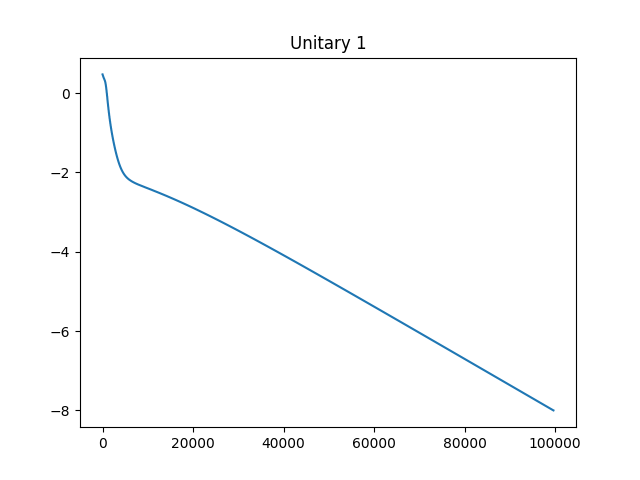

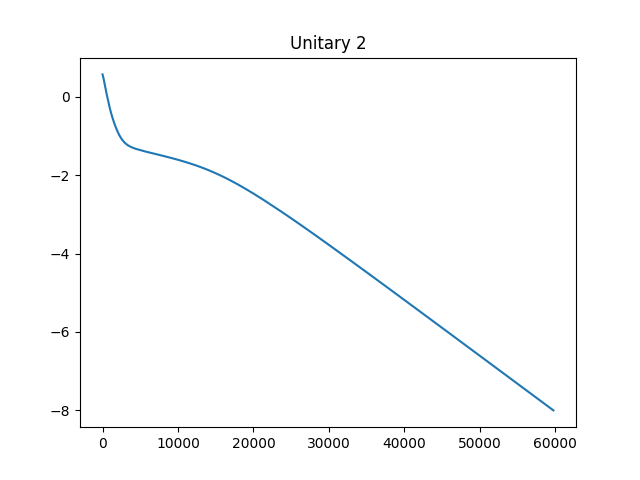

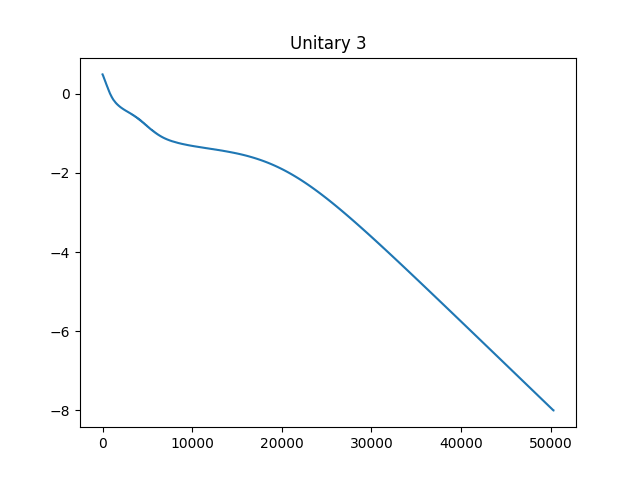

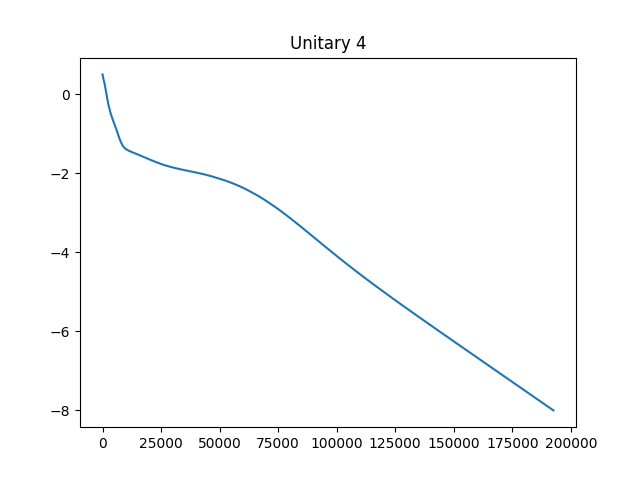

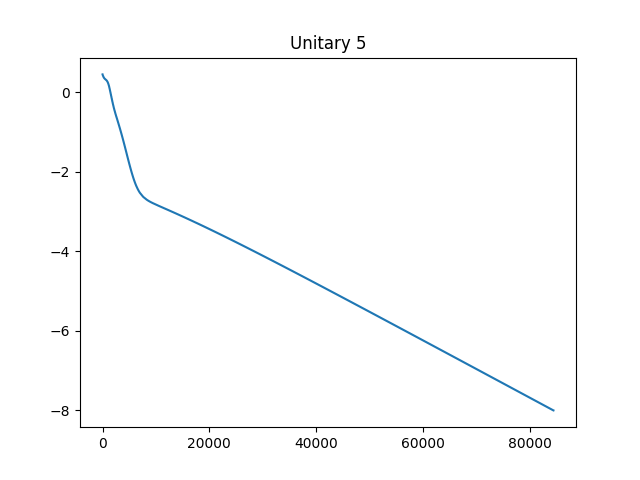

In [20]:
from IPython.display import display
from PIL import Image
img1 = Image.open("Unitary 1.png") 
img2 = Image.open("Unitary 2.png")  
img3 = Image.open("Unitary 3.png")  
img4 = Image.open("Unitary 4.png")  
img5 = Image.open("Unitary 5.png")  # Replace with your filename
display(img1,img2,img3,img4,img5)

1. How fast does it converge: Depends on the unitary - 10^4 iteration usually suffices
2. What's a stable learning rate - 0.01 seems to be okay - need to know how to verify
3. Does it reliably converge - Yes
4. Compare different unitaries and their convergence rate - how exactly ?

In [23]:
U_goal = unitary_group.rvs(4) # U to be achieved
print("U_goal =", U_goal) 
for h in range(5): 
    A = np.zeros((8,3))
    # randomly initialising the parameters
    for i in range(8):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    
    AOpt1 =np.copy(A)
    print("Iteration"+str(h+1),": Initial Parameters = ",AOpt1)
    # truncation condition
    stop_flag=0
    Uerr_array1=[] # to store error
    for i in range(10000):
        if stop_flag ==1:
            print("Truncation")
            break
        AOpt1,stop_flag = gradient_descent(AOpt1,10,0.01,U_goal)
    print("\nStarting error:",Uerr_array1[0])
    print("\nIterations:",len(Uerr_array1))
    plt.plot(np.log10(Uerr_array1))
    plt.title("Initialisation "+str(h+1))
    plt.savefig("Initialisation "+str(h+1))
    plt.close()



U_goal = [[ 0.07254484-0.11443456j -0.05728447-0.37488978j  0.04070771+0.65830913j
  -0.30477963+0.55668615j]
 [-0.1276822 +0.14431318j -0.71223832-0.3539158j  -0.20067435+0.22803986j
   0.06784914-0.48317208j]
 [-0.54618441-0.40981931j  0.11565019+0.39779759j -0.28946868+0.43750167j
   0.28559967-0.07311517j]
 [-0.67531351+0.14898094j -0.22573197-0.03261139j -0.14459628-0.42022813j
  -0.34304223+0.39314141j]]
Iteration1 : Initial Parameters =  [[11.28848383  1.11554277  9.02444834]
 [11.24682021  3.2324881   5.21381866]
 [ 1.61312004 12.40878411 11.32840615]
 [ 8.43217437  0.02049314  1.09414897]
 [ 3.11840539  5.31372615  9.01054535]
 [ 4.1384374  11.74739189  3.73197   ]
 [ 2.32160401  6.68602909  4.47483622]
 [ 5.61407879  9.27554591  8.20163507]]
Truncation

Starting error: 2.374510190098955

Iterations: 202544
Iteration2 : Initial Parameters =  [[11.78241789 11.83708908  9.83485985]
 [ 1.59920168 11.2021985   8.29386988]
 [ 8.53851057 11.63477277 10.03227476]
 [ 9.68180295 10.321

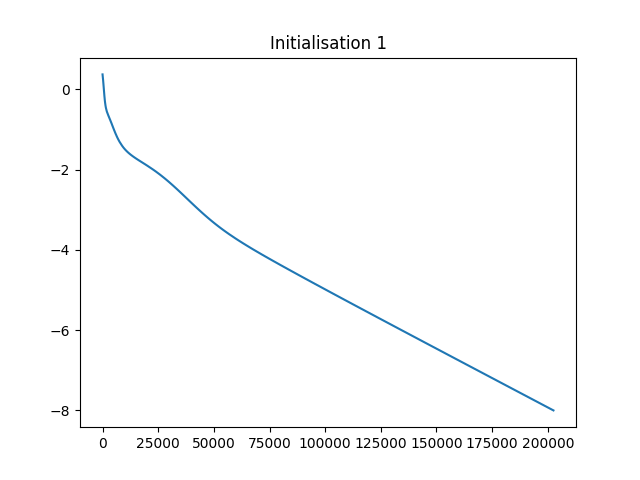

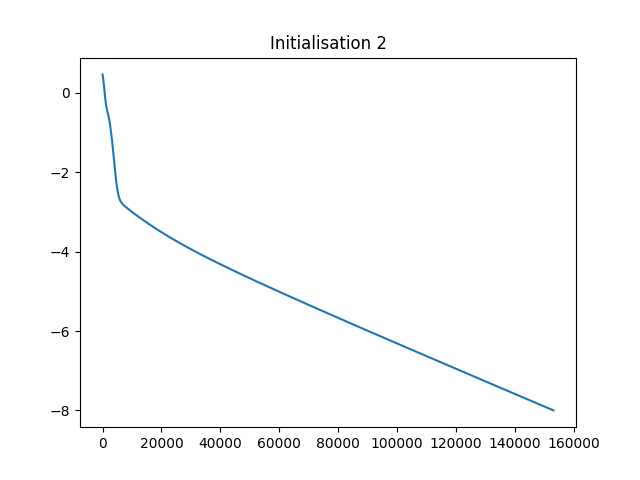

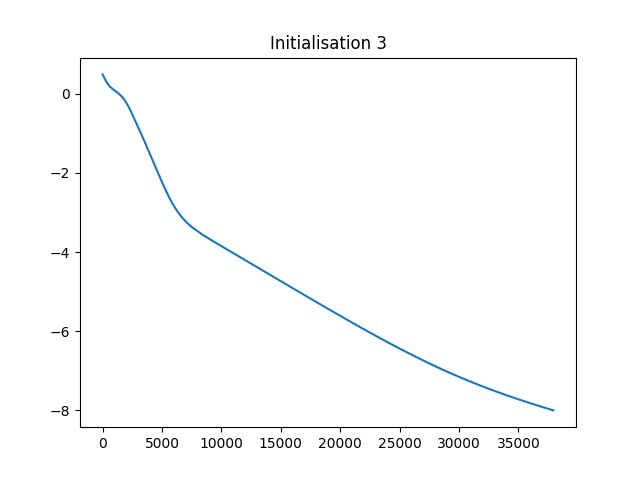

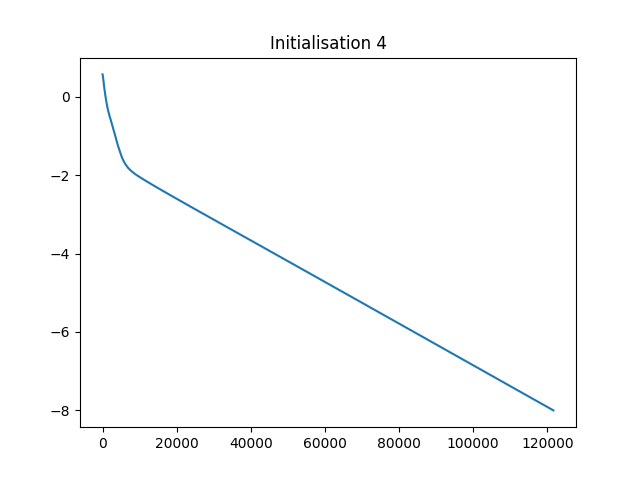

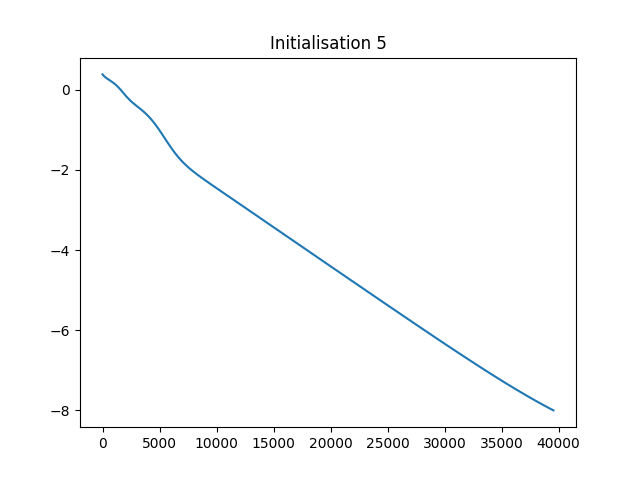

In [24]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

Comments: </br>
For the same unitary, the iterations range from 37946 to 202544